## Mridangam Stroke Classification Experiment

The goal of this notebook is to classify the strokes in the <a href = "https://compmusic.upf.edu/mridangam-stroke-dataset"> Mridangam Stroke dataset</a>.

### Sections
<ol>
<li>Collecting raw data and investigating its nature</li>
<li>Preprocessing of raw data </li>
<li>Feature extraction</li>
<li>Loading data in pandas</li>
<li>Feature selection</li>
<li>Comparing Classifiers</li>
<li>Classifier tuning and testing</li>
<li>DNN</li>
</ol>

Notes: 
- Several changes has been made to the original code of the Lecture1 MIR course. The relevant changes will be explained in their respective section. subtle changes will be explained with comments in the code.
- Each cell begins with a comment that explains what is done in that cell.

In [1]:
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import urllib.request
import zipfile

### 1. Collecting raw data and investigating its nature

Relevant changes: 
1. Plotting stroke samples: every time the cell (Plotting audio file for each stroke) is run, different samples of each stroke will be plotted.

In [4]:
# Downloading Mridangam Stroke Dataset

url = "https://zenodo.org/record/1265188/files/mridangam_stroke_1.0.zip"

print('Downloading Stroke Dataset')
filename = url.split('/')[-1]
urllib.request.urlretrieve(url,filename)

# Unzipping
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall()
zip_ref.close()
os.remove(filename) # Removing the zip file

main_dir = '.'.join( filename.split('.')[:-1] )
print('Data downloaded and unzipped to:', main_dir)

Data downloaded and unzipped to: mridangam_stroke_1.0


In [12]:
# Creating dictionary with filename lists for each stroke

main_dir = "mridangam_stroke_1.0"               

stroke_files = dict()                                       # Key: stroke - Values: file_name 
for root, dirs, files in os.walk(main_dir):
    for file in files:
        if file.endswith('.wav'):                           # WAV files
            file_name = os.path.join(root,file)
            stroke = file_name.split('-')[0].split('_')[-1] # Stroke is coded in the filename
            if stroke_files.get(stroke) == None:            # Create key if it does not exist and assign the respective value
                stroke_files[stroke] = [file_name]
            else:
                stroke_files.get(stroke).append(file_name)

# Printing the list of files
stroke_files

{'num': ['mridangam_stroke_1.0/D#/229151__akshaylaya__num-dsh-140.wav',
  'mridangam_stroke_1.0/D#/229119__akshaylaya__num-dsh-111.wav',
  'mridangam_stroke_1.0/D#/229014__akshaylaya__num-dsh-016.wav',
  'mridangam_stroke_1.0/D#/229142__akshaylaya__num-dsh-131.wav',
  'mridangam_stroke_1.0/D#/229018__akshaylaya__num-dsh-020.wav',
  'mridangam_stroke_1.0/D#/229051__akshaylaya__num-dsh-043.wav',
  'mridangam_stroke_1.0/D#/229086__akshaylaya__num-dsh-078.wav',
  'mridangam_stroke_1.0/D#/229001__akshaylaya__num-dsh-003.wav',
  'mridangam_stroke_1.0/D#/229090__akshaylaya__num-dsh-082.wav',
  'mridangam_stroke_1.0/D#/228999__akshaylaya__num-dsh-001.wav',
  'mridangam_stroke_1.0/D#/229103__akshaylaya__num-dsh-095.wav',
  'mridangam_stroke_1.0/D#/229116__akshaylaya__num-dsh-108.wav',
  'mridangam_stroke_1.0/D#/229132__akshaylaya__num-dsh-121.wav',
  'mridangam_stroke_1.0/D#/229074__akshaylaya__num-dsh-066.wav',
  'mridangam_stroke_1.0/D#/229024__akshaylaya__num-dsh-026.wav',
  'mridangam_strok

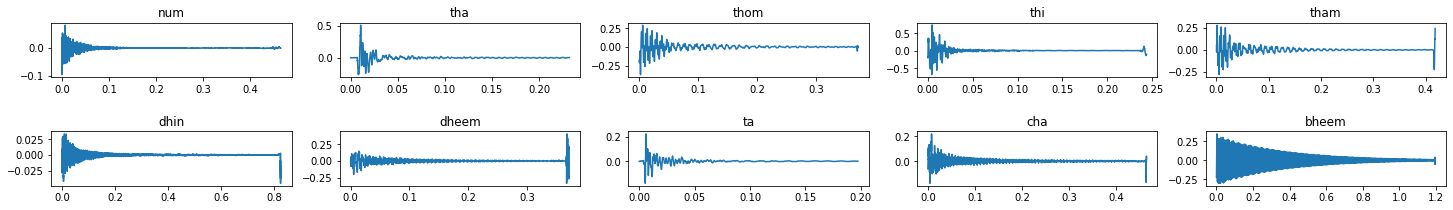

In [14]:
# Plotting audio file for each stroke

fs = 44100  

num_strokes_column = 5
num_strokes_row = np.ceil( len( stroke_files.keys() ) / num_strokes_column )
plt.figure(1, figsize=(5 * num_strokes_column, 3))
plt.subplots_adjust(hspace=1)

for i, stroke in enumerate( stroke_files.keys() ):
    file_ind_inlist = np.random.randint( len( stroke_files.get(stroke) ) )  # Random file in the list
    audio_file = stroke_files[stroke][file_ind_inlist]
    x = ess.MonoLoader(filename = audio_file, sampleRate = fs)()
    
    plt.subplot(num_strokes_row,num_strokes_column,(i+1))
    plt.plot(np.arange(len(x))/fs, x)
    plt.title(stroke)  

### 2. Preprocessing of raw data

Relevant changes:
1. Segmenting: each sample corresponds to a single stroke, but in some samples an additional transient appears in the final part. So, the original `split_file` function has been changed for an `isolate_strokes` function that gets rid of those additional transients using and energy threshold approach in the second half of the sample. 
2. Testing the raw data preprocessing function `isolate_stroke`: every time the cell is run, different samples of each stroke will be plotted.

In [15]:
def isolate_stroke(filename, params):
    fs = params["fs"]
    windowSize = params["windowSize"]
    hopSize = params["hopSize"]
    NRG_threshold_ratio = params["NRG_threshold_ratio"]
    
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    
    # FrameGenerator & Energy
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max( NRG[:len(NRG)//2] )     # Scaling with respect to the max of the first half of the frames
    
    # Isolation spike - Energy threshold
    spikes = np.nonzero( np.diff( NRG[len(NRG)//2:] > NRG_threshold_ratio ) )[0]
    if spikes.size:
        isolation_spike = len(NRG)//2 + spikes[0] + 1   # First spike found in the second half of the frames
    else:
        isolation_spike = len(NRG)                      # If not found -> isolation_spike is the final sample          
    isolate_stroke_wave = np.ones_like(NRG)
    isolate_stroke_wave[0] = 0                          # Start
    isolate_stroke_wave[isolation_spike:] = 0           # Stop
    
    # Start & stop indexes
    start_index = 0
    stop_index = isolation_spike * hopSize
    return (x, NRG, isolate_stroke_wave, start_index, stop_index)

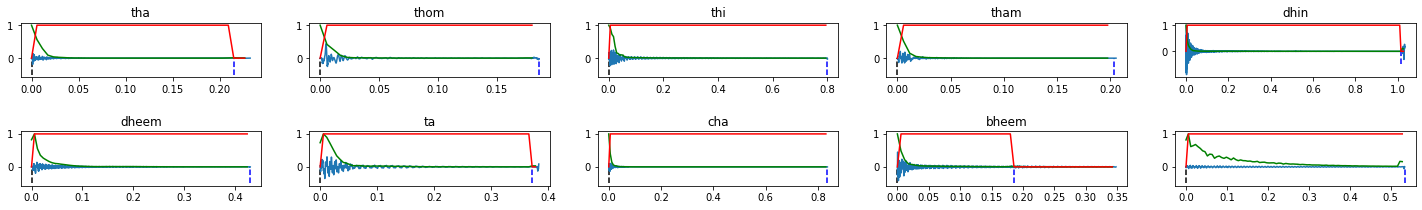

In [17]:
# Testing isolate_stroke function

fs = 44100
windowSize = 512
hopSize = windowSize // 2
NRG_threshold_ratio = 0.01 # Threshold expressed as ratio

# isolate_stroke function argument
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

fs = 44100
    
num_strokes_column = 5
num_strokes_row = np.ceil( len( stroke_files.keys() ) / num_strokes_column )
plt.figure(1, figsize=(5 * num_strokes_column, 3))
plt.subplots_adjust(hspace=1)

for i, stroke in enumerate( stroke_files.keys() ):
    file_ind_inlist = np.random.randint( len( stroke_files.get(stroke) ) )  # Random file in the list
    audio_file = stroke_files[stroke][file_ind_inlist]
    (x, NRG, isolate_stroke_wave, start_indexes, stop_indexes) = isolate_stroke(audio_file, params)
    
    # Plotting
    plt.title(stroke)
    plt.subplot(num_strokes_row,num_strokes_column,(i+1))
    plt.plot(np.arange(len(x))/fs, x, label = 'sound waveform')
    plt.plot(np.arange(NRG.size) * hopSize / fs, NRG, 'g', label = 'NRG')
    plt.plot(np.arange(isolate_stroke_wave.size) * hopSize / fs, isolate_stroke_wave,'r', label='isolation wave')
    plt.vlines(start_indexes / fs, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment start')
    plt.vlines(stop_indexes / fs, ymin = -0.5, ymax = 0, colors='b', linestyles='dashed', label='Segment stop')

In [22]:
# Isolating strokes

strokes_dir = os.path.join(main_dir,'strokes')
if not os.path.exists(strokes_dir): # Creating the directory
    os.mkdir(strokes_dir)

params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}
          
isolate_stroke_files = []
for stroke, files in stroke_files.items():
    file_count = 0
    for audio_file in files:
        (x, NRG, isolate_stroke_wave, start_index, stop_index) = isolate_stroke(audio_file, params)
        x_stroke = x[start_index: stop_index]               # Isolating strokes
        if(np.max(np.abs(x_stroke)) > 0.05):                # Final amplitude check (to avoid silent audios)
            x_stroke = x_stroke / np.max(np.abs(x_stroke))  # Amplitude normalisation
            filename = os.path.join(strokes_dir, stroke + '_' + str(file_count) + '.wav')
            ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_stroke)
            file_count +=1
            isolate_stroke_files.append(filename)

print(len(isolate_stroke_files),'stroke files created')

7031 stroke files created


### 3. Feature extraction

In [23]:
# Running music extractor for a file:

file = isolate_stroke_files[0]  # Pick the first file in the list
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n", scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

In [29]:
# Extracting features and writing in data.csv file in the strokes folder
# Each line in the data.csv file represents a sample with features and the class information as the last element

data_file = os.path.join(strokes_dir,'data.csv')
file_count = 0
with open(data_file, 'w') as writer:
    # Adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['stroke']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in isolate_stroke_files:
        if '.wav' in file:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            stroke = file.split('/')[-1].split('_')[0].lower()  # Class information
            line2write = str(selected_features)[1:-1] + ',' + stroke + '\n'
            writer.write(line2write)
            file_count += 1
            if file_count % 500 == 0:  # Print name of a file every 500 files
                print(file_count, "files processed, current file: ",file)
                
print("A total of ", file_count, "files processed")

500 files processed, current file:  mridangam_stroke_1.0/strokes/tha_8.wav
1000 files processed, current file:  mridangam_stroke_1.0/strokes/tha_508.wav
1500 files processed, current file:  mridangam_stroke_1.0/strokes/tha_1008.wav
2000 files processed, current file:  mridangam_stroke_1.0/strokes/thom_337.wav
2500 files processed, current file:  mridangam_stroke_1.0/strokes/thi_199.wav
3000 files processed, current file:  mridangam_stroke_1.0/strokes/thi_699.wav
3500 files processed, current file:  mridangam_stroke_1.0/strokes/thi_1199.wav
4000 files processed, current file:  mridangam_stroke_1.0/strokes/thi_1699.wav
4500 files processed, current file:  mridangam_stroke_1.0/strokes/thi_2199.wav
5000 files processed, current file:  mridangam_stroke_1.0/strokes/dhin_117.wav
5500 files processed, current file:  mridangam_stroke_1.0/strokes/dheem_215.wav
6000 files processed, current file:  mridangam_stroke_1.0/strokes/ta_247.wav
6500 files processed, current file:  mridangam_stroke_1.0/st

### 4. Loading data in pandas

In [4]:
# Loading data in pandas dataframe

data_file = "mridangam_stroke_1.0/strokes/data.csv"
data = pd.read_csv(data_file)   # Read data
data.head()                     # Let's see the first lines of our data

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke
0,0.990684,14.278906,5.170105,0.165473,0.054244,16.328604,14.423781,3.132927,1.595789,12.939737,...,1805.618652,2.442584,0.626868,5852115.00,3121675.25,0.351187,0.648563,0.056497,0.036329,num
1,0.990684,17.049881,5.084885,0.236260,0.046794,45.394115,31.848270,5.307144,2.654027,4.430664,...,347.351044,3.036520,0.542224,6185940.00,6287471.50,0.448889,0.744084,0.041303,0.023402,num
2,0.990684,11.261647,3.010016,0.133801,0.041272,4.975703,5.123416,2.009941,0.833954,46.044750,...,7880.496094,2.208610,0.566118,7937194.00,3214912.50,0.191320,0.687442,0.164144,0.095484,num
3,0.990684,16.869833,4.581037,0.256769,0.054552,60.315521,45.458889,6.121266,3.314157,4.311507,...,395.463257,3.106289,0.545341,6586933.50,7053440.50,0.404696,0.859206,0.035807,0.009577,num
4,0.990684,8.854460,2.177778,0.136314,0.028225,4.045063,2.716318,0.724264,0.438193,8.777337,...,159.998901,3.263978,0.476204,3921382.75,2527353.75,0.471355,0.727417,0.043837,0.014979,num


In [5]:
# Descriptive statistics of the features in pandas

print("Number of NaN values: ", data.isnull().sum().sum())
print(data.stroke.value_counts())
data.describe()

Number of NaN values:  0
thi      2208
tha      1171
ta        929
thom      638
num       491
dheem     468
dhin      402
tham      374
cha       304
bheem      46
Name: stroke, dtype: int64


,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,...,7031.000000,7031.000000,7031.000000,7031.000000,7.031000e+03,7.031000e+03,7031.000000,7031.000000,7031.000000,7031.000000
mean,0.990643,13.696560,3.891240,0.265616,0.062678,42.381345,44.999653,3.084038,2.105126,8.759898,...,785.989923,725.341425,4.277250,1.108372,4.944914e+06,4.713700e+06,0.341429,0.463642,0.035899,0.019375
std,0.003423,3.387110,1.286573,0.094984,0.028630,100.444131,105.887346,2.440176,2.039664,9.294472,...,1263.440354,1562.534378,1.628506,0.771590,1.777047e+06,2.334031e+06,0.255791,0.275929,0.035232,0.024184
min,0.703638,3.870666,0.097361,0.041811,0.000235,-0.531565,0.062863,-0.856536,0.061146,0.330640,...,129.199219,0.000000,1.760318,0.028898,1.054462e+06,5.888250e+03,0.000797,0.000797,0.003711,0.000000
25%,0.990684,11.142669,2.954814,0.197096,0.042435,9.164807,7.222266,1.608475,0.955861,3.454081,...,330.175781,112.252434,3.167004,0.590982,3.709266e+06,2.960064e+06,0.161566,0.247866,0.014915,0.004892
50%,0.990684,13.504786,3.906785,0.256790,0.057306,17.253546,15.253556,2.471548,1.481915,5.390777,...,456.112396,222.773590,3.941851,0.896086,4.719534e+06,4.516234e+06,0.266772,0.418977,0.023438,0.008733
75%,0.990684,15.897213,4.720406,0.314050,0.077658,37.674957,38.333118,3.774456,2.516337,10.809451,...,689.062500,364.388306,4.866063,1.339285,5.928076e+06,6.246216e+06,0.442468,0.630493,0.042476,0.023323
max,0.990684,25.174515,9.585800,0.614248,0.197942,1537.382324,1343.556396,29.805182,19.160645,93.753601,...,15161.221680,9450.376953,11.781043,5.790508,2.105675e+07,1.587518e+07,2.087870,3.723276,0.377414,0.207928


### 5. Preparing arrays

Relevant changes:
1. "Balancing" data: as the classes distribution is very skewed, the subsets where "balanced" with a stratify strategy as suggested in Andrew Ng's Machine Learning Yearning book (pag. 63). This is achieved with the `stratify` parameter in the `train_test_split` function of `sklearn`.
2. The `MinMaxScaler` was not applied in this section since the` StandardScaler` will be applied before the training of the classifiers..

In [6]:
# Preparing data arrays for features (inputs, X) and labels (outputs, y)

# Input values put in a matrix
X = data.iloc[:,:data.shape[1]-1].values 

# Creating output values
data.stroke = pd.Categorical(data.stroke)   # Convert to categorical data
y = np.array(data.stroke.cat.codes)         # Create label encoded outputs
print("Categories\n")
for code, category in enumerate( pd.Categorical(data.stroke).categories ):
    print(code, category) 
    
# Feature names
feature_names = data.columns.tolist()[:-1]

Categories

0 bheem
1 cha
2 dheem
3 dhin
4 num
5 ta
6 tha
7 tham
8 thi
9 thom


In [7]:
# Let's split data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, stratify = y, random_state = 0)
print("Size of train features matrix:", X_train.shape, "- Size of train output vector: ",y_train.shape)
print("Size of test features matrix:", X_test.shape, "- Size of test output vector: ",y_test.shape)

Size of train features matrix: (6327, 84) - Size of train output vector:  (6327,)
Size of test features matrix: (704, 84) - Size of test output vector:  (704,)


### 6. Feature selection

Relevant changes:
1. Features with zero variance were remove. These were `loudness_ebu128.loudness_range` and `loudness_ebu128.short_term.stdev`.
2. A univariate feature selection approach was followed with the `SelectKBest`algorithm from `sklearn`. To know how many features to choose, an `f_classif` test was applied in the training data, the features with `P-value == 0` were chosen. `K = 41` in this case.
3. A select from model feature selection approach was also explored with the `SelectFromModel`algorithm from `sklearn`.
4. It is interesting to note that within their respective top 10 features, both approaches coincide in 8 features. These are: `spectral_flux.stdev`, `spectral_rolloff.stdev`, `spectral_flux.mean`, `spectral_rolloff.mean`, `spectral_energyband_middle_low.mean`, `melbands_crest.mean’, ’barkbands_flatness_db.mean` and `spectral_centroid.stdev`.

In [8]:
# Imports for feature selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [9]:
# Removing features with zero variance

selection = VarianceThreshold()                                             # Keep all features with non-zero variance
fit_VT = selection.fit(X_train)
X_train_selection_VT = fit_VT.transform(X_train)
X_test_selection_VT = fit_VT.transform(X_test)

[feature_names[i] for i in np.where(selection.get_support() == False)[0]]   # Features with zero variance

['loudness_ebu128.loudness_range', 'loudness_ebu128.short_term.stdev']

In [10]:
# Univariate feature selection

scores_and_pvalues = f_classif(X_train_selection_VT, y_train)
KBest = len( np.where(scores_and_pvalues[1] == 0)[0] ) # Number of features with pvalues == 0

fit_KBest = SelectKBest(score_func=f_classif, k=KBest).fit(X_train_selection_VT, y_train)
X_train_selection_KBest = fit_KBest.transform(X_train_selection_VT)
X_test_selection_KBest = fit_KBest.transform(X_test_selection_VT)

idx_KBest = np.argsort(fit_KBest.scores_)[::-1]         # Indexes of the features sorted by their scores
selected_features_KBest = [feature_names[i] for i in idx_KBest[:KBest]]
print("Top 10 using filter selection")
selected_features_KBest[:10]

Top 10 using filter selection


['spectral_flux.stdev',
 'spectral_rolloff.stdev',
 'spectral_flux.mean',
 'loudness_ebu128.momentary.stdev',
 'spectral_rolloff.mean',
 'spectral_energyband_middle_low.mean',
 'barkbands_flatness_db.mean',
 'melbands_crest.mean',
 'spectral_centroid.stdev',
 'spectral_energyband_high.stdev']

In [11]:
# Feature selection using SelectFromModel

clf = ExtraTreesClassifier(n_estimators=100, max_features=1, random_state=0) # n_estimators=100 -> default value in version 0.22
clf = clf.fit(X_train_selection_VT, y_train)

model = SelectFromModel(clf, prefit=True)
X_train_selection_SFM = model.transform(X_train_selection_VT)
X_test_selection_SFM = model.transform(X_test_selection_VT)

importances = clf.feature_importances_
idx_SFM = np.argsort(importances)[::-1]         # Indexes of the features sorted by their importances
num_sf = np.shape(X_train_selection_SFM)[1]     # Number of selected features
selected_features_SFM = [feature_names[i] for i in idx_SFM[:num_sf]]
print("Top 10 using SelectFromModel")
selected_features_SFM[:10]

Top 10 using SelectFromModel


['spectral_flux.mean',
 'spectral_rolloff.mean',
 'erbbands_flatness_db.mean',
 'melbands_crest.mean',
 'spectral_rolloff.stdev',
 'spectral_energyband_middle_low.mean',
 'barkbands_flatness_db.mean',
 'spectral_flux.stdev',
 'spectral_centroid.stdev',
 'dissonance.mean']

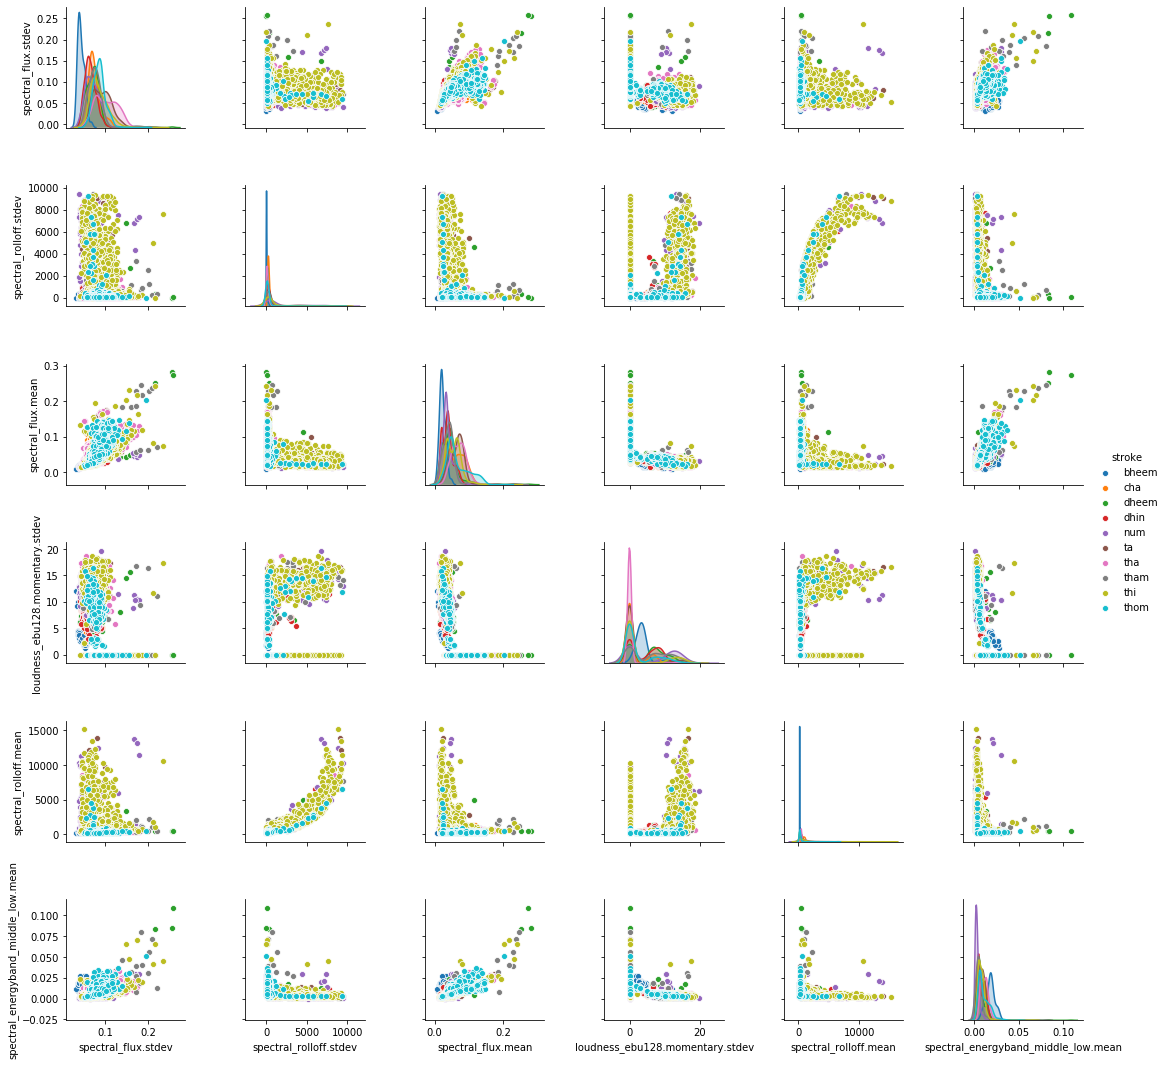

In [10]:
# Drawing scatterplots for joint relationships and histograms for univariate distributions - 6 best features

sns.pairplot( data[ np.append(selected_features_KBest[:6],"stroke")], hue = "stroke");

In [12]:
# Comparing Classifiers

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear"),
    SVC(),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()]

names = ["KNN", "Linear SVM", "RBF SVM", "Neural Net", "Naive Bayes"]

# Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []
    
# Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_t_train, x_t_val, y_t_train, y_t_val = train_test_split(X_train_selection_KBest, y_train, stratify = y_train, test_size = 1/num_tests, random_state = iteration_number)
    
    # Normalisation of the data (learned from training data, applied to train and test (val) data)
    scaler = preprocessing.StandardScaler().fit(x_t_train)
    norm_x_t_train = scaler.transform(x_t_train)
    norm_x_t_val = scaler.transform(x_t_val)
    
    # Test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_t_train, y_t_train)          # Train
        score = clf.score(norm_x_t_val, y_t_val)    # Test
        scores[name].append(score)
        
for name, score in scores.items():
    print("Values: {0},\t{1}: acc = {2:1.3f}, +-{3:1.3f}".format(np.around(score, decimals = 3), name, np.mean(score), np.std(score)))


Values: [0.885 0.886 0.896 0.904 0.912 0.916 0.897 0.896 0.904 0.929],	KNN: acc = 0.902, +-0.013
Values: [0.919 0.904 0.913 0.916 0.927 0.935 0.915 0.894 0.921 0.932],	Linear SVM: acc = 0.918, +-0.012
Values: [0.915 0.915 0.929 0.93  0.94  0.948 0.923 0.921 0.934 0.949],	RBF SVM: acc = 0.930, +-0.012
Values: [0.905 0.913 0.915 0.921 0.937 0.938 0.927 0.902 0.924 0.948],	Neural Net: acc = 0.923, +-0.014
Values: [0.701 0.67  0.7   0.716 0.69  0.709 0.708 0.706 0.69  0.725],	Naive Bayes: acc = 0.702, +-0.015


### 7. Comparing Classifiers

Relevant changes:
1. The features selected from the `SelectKBest` approach are those used here since they performed better than those of` SelectFromModel` approach. 

In [78]:
# Comparing Classifiers

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()]

names = ["KNN", "Linear SVM", "RBF SVM", "Neural Net", "Naive Bayes"]

# Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []
    
# Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_t_train, x_t_val, y_t_train, y_t_val = train_test_split(X_train_selection_KBest, y_train, stratify = y_train, test_size = 1/num_tests, random_state = iteration_number)
    
    # Normalisation of the data (learned from training data, applied to train and test (val) data)
    scaler = preprocessing.StandardScaler().fit(x_t_train)
    norm_x_t_train = scaler.transform(x_t_train)
    norm_x_t_val = scaler.transform(x_t_val)
    
    # Test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_t_train, y_t_train)          # Train
        score = clf.score(norm_x_t_val, y_t_val)    # Test
        scores[name].append(score)
        
for name, score in scores.items():
    print("Values: {0},\t{1}: acc = {2:1.3f}, +-{3:1.3f}".format(np.around(score, decimals = 3), name, np.mean(score), np.std(score)))

Values: [0.893 0.893 0.907 0.896 0.908 0.921 0.897 0.886 0.907 0.934],	KNN: acc = 0.904, +-0.014
Values: [0.919 0.904 0.913 0.916 0.927 0.935 0.915 0.894 0.921 0.932],	Linear SVM: acc = 0.918, +-0.012
Values: [0.915 0.915 0.929 0.93  0.94  0.948 0.923 0.921 0.934 0.949],	RBF SVM: acc = 0.930, +-0.012
Values: [0.907 0.91  0.915 0.919 0.937 0.932 0.921 0.902 0.921 0.948],	Neural Net: acc = 0.921, +-0.013
Values: [0.701 0.67  0.7   0.716 0.69  0.709 0.708 0.706 0.69  0.725],	Naive Bayes: acc = 0.702, +-0.015


### 8. Classifier tuning and testing

1. Classifier selection: `RBF SVM` was the classifier with highest performance.
2. To perform the hyperparameter tuning, the training data set was again divided for training and cross-validation.
3. Hyper-parameter tuning: this tuning process and its correspond subset split were added in order to improve the performance of the classifier

In [85]:
# Splitting trainig data for training (t_train) and cross-validation (t_val)
x_t_train, x_t_val, y_t_train, y_t_val = train_test_split(X_train_selection_KBest, y_train, stratify = y_train, test_size = 0.1, random_state = 9)
    
# Normalisation
scaler = preprocessing.StandardScaler().fit(x_t_train)
norm_x_t_train = scaler.transform(x_t_train)
norm_x_t_val = scaler.transform(x_t_val)
norm_x_test = scaler.transform(X_test_selection_KBest)

In [89]:
# Hyper-parameter tuning

highest_val_accuracy = 0
C_best = 0

for C_tuning in np.linspace(0.1, 10, 100):
    selected_model = SVC(C=C_tuning)
    selected_model.fit(norm_x_t_train, y_t_train)
    val_accuracy = selected_model.score(norm_x_t_val, y_t_val)
    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy 
        C_best = C_tuning

selected_model = SVC(C=C_best)
selected_model.fit(norm_x_t_train, y_t_train)        
print('Training accuracy:', selected_model.score(norm_x_t_train, y_t_train))
print('Cross-validation accuracy:', selected_model.score(norm_x_t_val, y_t_val))

Training accuracy: 0.9689146469968388
Cross-validation accuracy: 0.9620853080568721


In [91]:
# Testing the classifier

print('Test accuracy:', selected_model.score(norm_x_test, y_test))

y_pred = selected_model.predict(norm_x_test)
print("\nNumber of test samples: ", len(y_pred))
print(classification_report(y_test, y_pred))

Test accuracy: 0.9446022727272727

Number of test samples:  704
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.97      0.97      0.97        30
           2       0.90      0.98      0.94        47
           3       0.97      0.97      0.97        40
           4       0.98      0.96      0.97        49
           5       0.94      0.88      0.91        93
           6       0.95      0.96      0.95       117
           7       0.97      0.92      0.95        38
           8       0.94      0.95      0.94       221
           9       0.92      0.95      0.94        64

    accuracy                           0.94       704
   macro avg       0.95      0.95      0.95       704
weighted avg       0.95      0.94      0.94       704



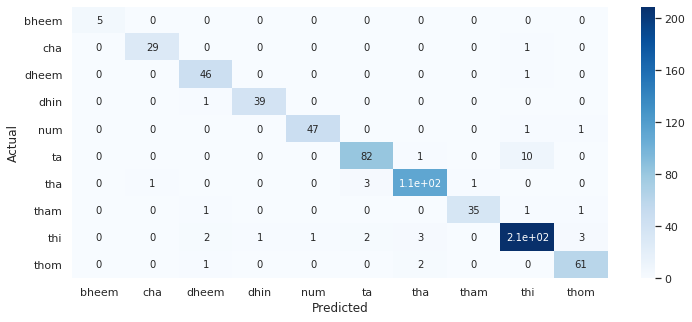

In [92]:
# Confusion Matrix

classes = np.unique(data.stroke)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (12, 5))
sns.set(font_scale = 1)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 10}, annot = True);

### 9. DNN

Relevant changes:
1. The loss function for the model compiler was changed to `categorial_crossentropy` since this is multiclass prediction. With this function set, the default accuracy metric is the `categorical_accuracy`, while with the `binary_crossentropy` function, the default accuracy metric is the `binary_accuracy`, which can be misleading in this case.
2. The glorot initializer was applied to the hidden and output layers.
3. The activation of the output layer was changed to `softmax`.

In [17]:
from keras.models import Sequential
from keras import layers
from keras.initializers import glorot_uniform

In [18]:
# Normalisation
scaler = preprocessing.StandardScaler().fit(X_train_selection_KBest)
norm_x_train = scaler.transform(X_train_selection_KBest)
norm_x_test = scaler.transform(X_test_selection_KBest)

# One-hot encoding
onehot_encoder = preprocessing.OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train shape = ", y_train_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train shape =  (6327, 10)
One-hot encoded y_test shape =  (704, 10)


In [94]:
# DNN model

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 60, kernel_initializer = glorot_uniform(seed=0)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.1, seed = 0))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 40, kernel_initializer = glorot_uniform(seed=0)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.1, seed = 0))
    
    # 3. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_3', units = 30, kernel_initializer = glorot_uniform(seed=0)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 10, kernel_initializer = glorot_uniform(seed=0)))
    model.add(layers.Activation('softmax'))
    
    return model

In [95]:
# Composing model
model = compose_model(X_train_selection_KBest.shape[1])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 41)                164       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 60)                2520      
_________________________________________________________________
batch_normalization_25 (Batc (None, 60)                240       
_________________________________________________________________
activation_35 (Activation)   (None, 60)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 60)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 40)                2440      
_________________________________________________________________
batch_normalization_26 (Batc (None, 40)              

In [96]:
# Compiling and fitting the model
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ["categorical_accuracy"])
history = model.fit(norm_x_train, y_train_onehot, batch_size = 250, epochs = 250, validation_split=0.1, verbose=0)

In [97]:
print('Training loss:', history.history['loss'][-1])
print('Training accuracy:', history.history['categorical_accuracy'][-1])

print('\nCross-validation loss:', history.history['val_loss'][-1])
print('Cross-valitarion accuracy:', history.history['val_categorical_accuracy'][-1])

Training loss: 0.15023801857582678
Training accuracy: 0.95328414

Cross-validation loss: 0.24228096606230473
Cross-valitarion accuracy: 0.9478672742843628


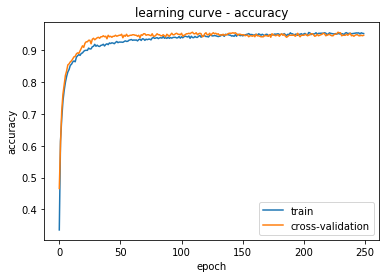

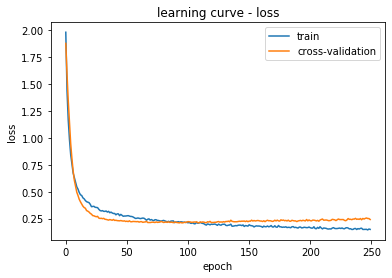

In [98]:
# Plotting

# Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cross-validation'], loc='lower right')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('learning curve - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cross-validation'], loc='upper right')
plt.show()

In [99]:
# Testing the classifier

score = model.evaluate(norm_x_test, y_test_onehot, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

y_pred_prob = model.predict(norm_x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print("\nNumber of test samples: ", len(y_pred))
print(classification_report(y_test, y_pred))


Test loss: 0.3260387536138296
Test accuracy: 0.9389204382896423

Number of test samples:  704
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.97      0.97      0.97        30
           2       0.90      0.98      0.94        47
           3       0.97      0.95      0.96        40
           4       0.94      0.94      0.94        49
           5       0.93      0.90      0.92        93
           6       0.94      0.95      0.94       117
           7       0.94      0.84      0.89        38
           8       0.95      0.94      0.94       221
           9       0.91      0.97      0.94        64

    accuracy                           0.94       704
   macro avg       0.95      0.94      0.94       704
weighted avg       0.94      0.94      0.94       704

